# Compare HSC and VISTA Z and Y aperture mags

In [4]:
from astropy.table import Table
import numpy as np


import matplotlib
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt

In [25]:
cat = Table.read('./data/HSC_z_y_comparison.fits')

In [26]:
cat[:5]

m_ap60_hsc_z,merr_ap60_hsc_z,m_ap60_hsc_y,merr_ap60_hsc_y,m_ap60_vista_z,merr_ap60_vista_z,m_ap60_vista_y,merr_ap60_vista_y,m_ap90_hsc_z,merr_ap90_hsc_z,m_ap90_hsc_y,merr_ap90_hsc_y,m_ap90_vista_z,merr_ap90_vista_z,m_ap90_vista_y,merr_ap90_vista_y,isDeblended,inInnerRegions,isSkyObject,isPrimary,isStellar,isGoodFlux,flag,ra,dec
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,float64,float64
23.898517889960388,0.04369989757266984,23.224473382457784,0.06797244281245095,23.82186836769418,0.010135882529701063,22.56115564637529,0.00535833064860545,23.21087280185737,0.03479703168350597,22.468833927674382,0.05099540028072632,23.045348241036365,0.007474756204601838,21.766872738998046,0.0038869225223633827,True,False,False,False,False,False,False,0.6374476507162742,-0.08930773456473962
22.47773668636368,0.01228089267274052,22.32126271968521,0.028016087765502285,22.6879126413351,0.0035794290919908644,22.37891017328071,0.004531730304145845,22.13092890981038,0.013342076914774079,21.930781235705584,0.029202499550167887,22.28534711843156,0.003715429727665143,21.936995751602378,0.004545582193443232,True,False,False,False,False,False,False,0.6367240838818662,-0.08930618870591925
24.10024039956417,0.054760232526669186,23.987804645557382,0.14937539987265872,24.739581705130394,0.023551578330117572,23.92373298840822,0.01877554808332796,23.34270769749178,0.041285278542231685,23.11714649062242,0.10141132121208417,23.90719777680947,0.016501135891290177,23.08619450070857,0.013083493951481857,True,False,False,False,False,False,False,0.6364485565669454,-0.08930896142291907
26.237789646275246,0.3824776447389918,27.243581668473848,2.8667936316924116,26.702140133892847,0.15371377640468925,28.6643312067722,1.458885124064305,25.804715596812446,0.38785810846495855,26.583630334264413,2.347654259422075,25.86761750287973,0.10740069482822909,26.451883747023782,0.28666745367646185,True,False,False,False,False,False,False,0.6358533387706246,-0.0893096501823165
25.5723750393472,0.20546048091145966,25.21137915879939,0.45305174435626033,25.149752486033105,0.036814266088577526,24.720746199981235,0.03863087066685398,24.506118113984602,0.1167385150866304,24.609748804032332,0.39180296379979196,24.056036485849305,0.020267587440975805,23.71897402918968,0.02314321430139342,True,False,False,False,False,False,False,0.635473146832569,-0.08931007365137661


In [27]:
len(cat)

495632

In [32]:
np.sum(cat['flag'])

48259

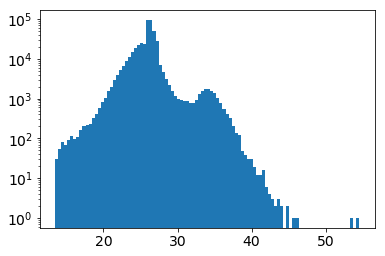

In [29]:
plt.hist(cat['m_ap60_vista_z'][~np.isinf(cat['m_ap60_vista_z'])], bins=100)
plt.yscale('log')

In [9]:
!mkdir figs

In [ ]:
def mag_to_flux(magnitudes, errors_on_magnitudes=None):
    """Convert AB magnitudes and errors to fluxes
    Given AB magnitudes and associated errors, this function returns the
    corresponding fluxes and associated flux errors (in Jy).
    The fluxes are computed with this formula:
        F = 10^((8.9 - Mag)/2.5)
    and the errors on fluxes with this one:
        F_err = ln(10)/2.5 * F * Mag_err
    Parameters
    ----------
    magnitudes: float or array-like of floats
        AB magnitudes of the sources.
    errors_on_magnitudes: float or array-like of floats
        Error on each magnitudes. None if there are no errors.
    Returns
    -------
    fluxes: float or array-like of floats
        The fluxes in Jy.
    errors: float or array-like of floats
        The errors on fluxes in Jy or None.
    """
    magnitudes = np.array(magnitudes)
    fluxes = 10 ** ((8.9 - magnitudes)/2.5)

    if errors_on_magnitudes is not None:
        errors_on_magnitudes = np.array(errors_on_magnitudes)
        errors = np.log(10)/2.5 * fluxes * errors_on_magnitudes
    else:
        errors = None

    return fluxes, errors

Comparing Z band AB 2 arc sec aperture magnitudes from HSC-Z 6pix radius ap and VISTA-Z 6pix radius ap
Mean offset = -0.4368
Median offset = -0.4139
Weighted bias (14.5<mag<15.5) = -0.437


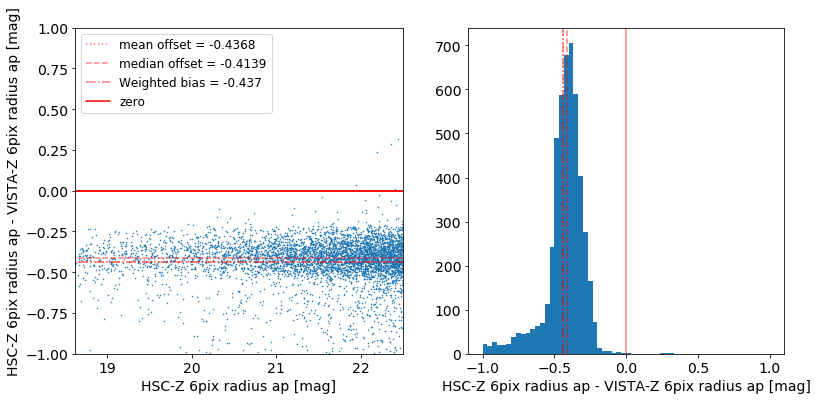

<Figure size 432x288 with 0 Axes>

In [41]:
def mag_diff(x,xerr,y,yerr, labels,savefig=True):
    print("Comparing {} band AB 2 arc sec aperture magnitudes from {} and {}".format(labels[2],labels[0],labels[1]))
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    #ax3 = plt.subplot(gs2[:, -1], sharey=ax2)
    
    #notInf = ~np.isinf(x) & ~np.isinf(y)
    #x = x[notInf]
    #y = y[notInf]

 
    m = (
        mask 
        #& (merge['help_m_ap_vista_y'] < 30)
        #& (merge['vhs_stellarity']>0.9)
    )

    mean_offset = np.nanmean(x - y)
    median_offset = np.nanmedian(x - y)
    print("Mean offset = {}".format(round(mean_offset,4)))
    print("Median offset = {}".format(round(median_offset,4)))
    
    total_var = xerr**2 + yerr**2 +0.03**2 #the extra 0.03 is an estimate of the abs. cal. error for vista
    unsaturated = (x>18.5) & (x<22.5)

    weighted_bias = np.nansum(
        (
            x[unsaturated]
            -y[unsaturated]
        )/total_var[unsaturated]
    )/np.nansum(1./total_var[unsaturated])
    print('Weighted bias (14.5<mag<15.5) = {}'.format(round(weighted_bias,4)))
    
    
    ax1.plot([0,26],[mean_offset,mean_offset], linestyle='dotted', c='r', alpha=0.5,
             label = 'mean offset = {}'.format(round(mean_offset,4)))
    ax1.plot([0,26],[median_offset,median_offset], linestyle='dashed', c='r', alpha=0.5,
         label = 'median offset = {}'.format(round(median_offset,4)))
    ax1.plot([0,26],[weighted_bias,weighted_bias], linestyle='dashdot', c='r', alpha=0.5,
         label = 'Weighted bias = {}'.format(round(weighted_bias,4)))
    ax1.plot([0,26],[0,0], c='r', label='zero')
    ax1.legend( prop={'size': 12}, loc='upper left')
    ax1.scatter(x,   x - y, 
            alpha=1.0, s=0.3)
    
    
    ax1.set_xlabel('{} [mag]'.format(labels[0]))
    ax1.plot([0,26],[0,0], c='r')
    
    upper = np.min([25.,np.nanmax(x),np.nanmax(y)+1] )
    ax1.set_xlim([np.nanmin(x),np.nanmax(x)])
    ax1.set_ylim([-1,1])
    ax1.set_ylabel('{} - {} [mag]'.format(labels[0],labels[1]))
    
    ax2.hist(x - y,range=[-1,1], bins=60)
    #ax2.set_xlim([-2,2])
    ax2.set_xlabel('{} - {} [mag]'.format(labels[0],labels[1]))
    ax2.axvline(0, c='r', alpha=0.5)
    ax2.axvline(mean_offset,linestyle='dotted', c='r', alpha=0.5)
    ax2.axvline(median_offset,linestyle='dashed', c='r', alpha=0.5)
    ax2.axvline(weighted_bias,linestyle='dashdot', c='r', alpha=0.5)
    
    
    #plt.rc('font', family='serif', serif='Times')
    plt.rc('text') #, usetex=True)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', labelsize=14)
    plt.show()


    if savefig:
        plt.savefig('./figs/mag_compare_{}_{}.pdf'.format(labels[0],labels[1]), bbox_inches='tight')
        plt.savefig('./figs/mag_compare_{}_{}.png'.format(labels[0],labels[1]), bbox_inches='tight')
    
    
    
mask = cat['flag']
mask &= cat['m_ap60_hsc_z'] >18.5
mask &= cat['m_ap60_hsc_z'] <22.5
mask &= cat['m_ap60_vista_z'] >10
mask &= cat['m_ap60_vista_z'] <30
mag_diff(

    cat[mask]['m_ap60_hsc_z'],
    cat[mask]['merr_ap60_hsc_z'],
    cat[mask]['m_ap60_vista_z'],
    cat[mask]['merr_ap60_vista_z'],
    ['HSC-Z 6pix radius ap','VISTA-Z 6pix radius ap', 'Z'])

Comparing Z band AB 2 arc sec aperture magnitudes from HSC-Z 9pix radius ap and VISTA-Z 9pix radius ap
Mean offset = -0.3888
Median offset = -0.3623
Weighted bias (14.5<mag<15.5) = -0.3846


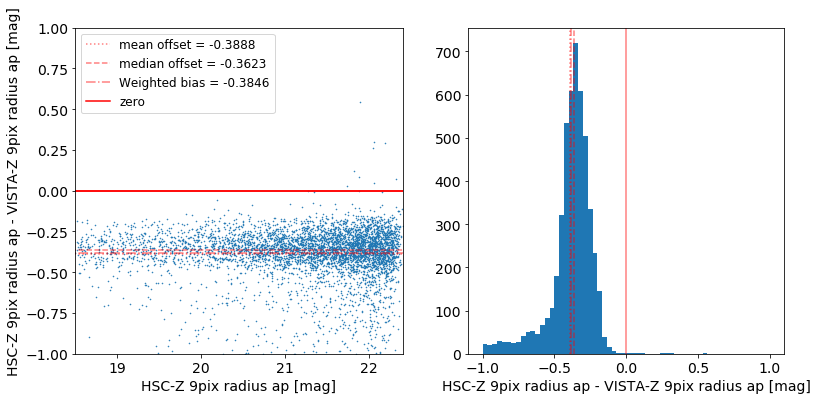

<Figure size 432x288 with 0 Axes>

In [42]:
mask = cat['flag']
mask &= cat['m_ap90_hsc_z'] >18.5
mask &= cat['m_ap90_hsc_z'] <22.5
mask &= cat['m_ap90_vista_z'] >10
mask &= cat['m_ap90_vista_z'] <30
mag_diff(

    cat[mask]['m_ap90_hsc_z'],
    cat[mask]['merr_ap90_hsc_z'],
    cat[mask]['m_ap90_vista_z'],
    cat[mask]['merr_ap90_vista_z'],
    ['HSC-Z 9pix radius ap','VISTA-Z 9pix radius ap', 'Z'])

Comparing Y band AB 2 arc sec aperture magnitudes from HSC-Y 6pix radius ap and VISTA-Y 6pix radius ap
Mean offset = -0.1907
Median offset = -0.1861
Weighted bias (14.5<mag<15.5) = -0.1889


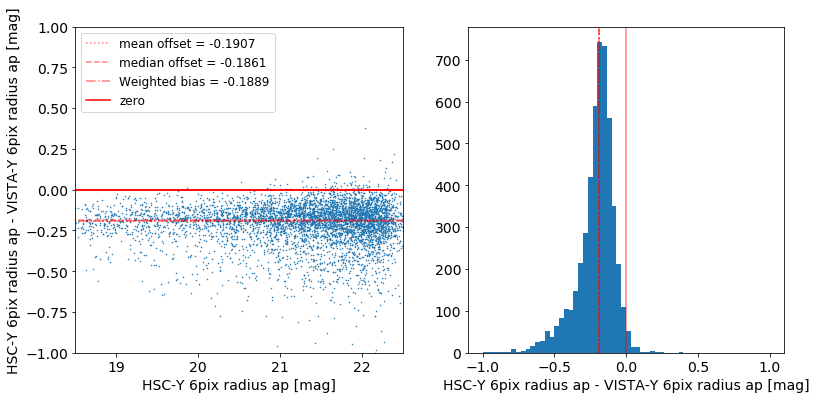

<Figure size 432x288 with 0 Axes>

In [43]:
mask = cat['flag']
mask &= cat['m_ap60_hsc_y'] >18.5
mask &= cat['m_ap60_hsc_y'] <22.5
mask &= cat['m_ap60_vista_y'] >10
mask &= cat['m_ap60_vista_y'] <30
mag_diff(

    cat[mask]['m_ap60_hsc_y'],
    cat[mask]['merr_ap60_hsc_y'],
    cat[mask]['m_ap60_vista_y'],
    cat[mask]['merr_ap60_vista_y'],
    ['HSC-Y 6pix radius ap','VISTA-Y 6pix radius ap', 'Y'])

Comparing Y band AB 2 arc sec aperture magnitudes from HSC-Y 9pix radius ap and VISTA-Y 9pix radius ap
Mean offset = -0.1806
Median offset = -0.1603
Weighted bias (14.5<mag<15.5) = -0.1784


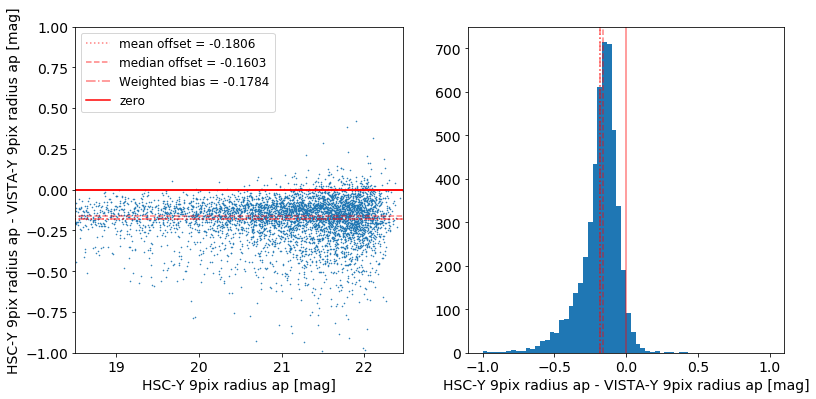

<Figure size 432x288 with 0 Axes>

In [44]:
mask = cat['flag']
mask &= cat['m_ap90_hsc_y'] >18.5
mask &= cat['m_ap90_hsc_y'] <22.5
mask &= cat['m_ap90_vista_y'] >10
mask &= cat['m_ap90_vista_y'] <30
mag_diff(

    cat[mask]['m_ap90_hsc_y'],
    cat[mask]['merr_ap90_hsc_y'],
    cat[mask]['m_ap90_vista_y'],
    cat[mask]['merr_ap90_vista_y'],
    ['HSC-Y 9pix radius ap','VISTA-Y 9pix radius ap', 'Y'])